# Relevant Packages

In [1]:
#Import packages
import IPython.display as ipd
import numpy as np
import pyaudio, wave
import math
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from scipy.fftpack import dct

In [2]:
#pip install  keyboard

In [3]:
def bark2hz(z):
    #Converts frequencies Bark to Hertz (Hz)
    hz = 600 * np.sinh(z/6);
    return hz

In [4]:
def hz2bark(f):
    #Converts frequencies Hertz (Hz) to Bark
    # Inverse of Hynek's formula (see bark2hz)
    z = 6 * np.arcsinh(f/600);
    return z

# Flow：

1. Pre-Emphasize the whole chunk
2. Windowing to get the frames
3. Zero padding to prepare for the Fast Fourier Transform (FFT)
4. Fast Fourier Transform to get the power spectrum
5. Filter bank
6. Take logarithm to get the Log Mel spectrum
7. Discrete Cosine Transform (DCT)
8. Get the MFCC

# Functions

## Pre-Emphasizing a speech signal

The spectrum of the speech signal naturally has lower energy at higher frequencies. This spectral tilt can be
corrected by pre-emphasizing the signal. Here we apply a pre-emphasis filter to amplify the high frequencies. The filter we use is: $$S_ p[n] = S[n] – 0.95*S[n-1]$$

In [5]:
#Pre-emphasize the speech signal by a filter equation
def Preemphasizing(chunk):
    #input is the chunk with length set to 1600, it could also be the whole signal document (preferred)
    pe=np.zeros(len(chunk))
    pe[0]=chunk[0]
    for i in range(1,len(chunk)):
        pe[i]=chunk[i]-0.95*chunk[i-1]
    return pe

## Windowing the speech signal

In [6]:
#Apply window function to the frames
def windowing(frame,mode="Hamming"):
    #do windowing for the signal frame
    n=len(frame)
    #windowing the speech signal
    if mode=="Hamming":
        frame=frame*np.hamming(n)
    elif mode=="Hanning":
        frame=frame*np.hanning(n)
    elif mode=="Blackman":
        frame=frame*np.blackman(n)
    return frame

## Zero padding the frames 

Prepare for the Fast-Fourier Transform (FFT).

In [7]:
#Pad zero to make the frame a desired length (exponential of 2)
def zero_padding(frame,FFT_size=512):
    #zero padding for FFT
    frame_length=len(frame)
    padding_length=FFT_size-frame_length
    zeros=np.zeros((padding_length,))
    zero_padding_frame=np.concatenate((frame,zeros))
    return zero_padding_frame

## Fast-Fourier Transform (FFT) 

Get the power spectrum.

In [8]:
#Fast-Fourier Transform
def FFT(frame,FFT_size=512):
    #http://dong.sh/posts/difffftandrfft/
    #we use the rfft rather than the fft, the difference is shown in the website above.
    # in short rfft give a result of half of the fft_size
    mag_frame = np.absolute(np.fft.rfft(frame, FFT_size))  # Magnitude of the FFT
    power_spectrum = ((1.0 / FFT_size) * ((mag_frame) ** 2))  # Power Spectrum
    return power_spectrum

##  Warping the frequency axis Hz 2 Mel & Mel 2 Hz

In [9]:
#Herz to Mel
def hz2mel(f):
    #  Convert frequencies f (in Hz) to mel 'scale'.
    #Mel warping function
    z = 2595 * np.log10(1+f/700);
    return z

In [10]:
#Mel to Herz
def mel2hz(z):
    # Convert 'mel scale' frequencies into Hz
    f = 700*(np.power(10,z/2595)-1)  #CHR use np.power to simulate ".^" in matlab
    return f

## Filter Bank

In [11]:
def filterbanks(power_spectrum,lower_boundHz=133.33,upper_boundHz=6855.4976,num_banks=40,FFT_size=512):
    upper_boundMel=hz2mel(upper_boundHz)
    lower_boundMel=hz2mel(lower_boundHz)
    #Uniformly sample in Mel scale to get 40 triangular filters
    mel_points=np.linspace(lower_boundMel,upper_boundMel,num_banks+2)
    #Transform to frequency scale and generate non-uniformly distributed triangular filters
    hz_points=mel2hz(mel_points)
    #After FFT, the sample become half of the original (integer)
    bin=np.floor((FFT_size + 1)/2*hz_points/(upper_boundHz-lower_boundHz))
    #Correspond the frequency points to the power spectrum after FFT
   #print(bin)
    #Normalization because of the lower bound
    bin=bin-bin[0]
    fbank=np.zeros((num_banks,int(np.floor(FFT_size/2+1))))
    for m in range(1,num_banks+1):
        f_m_low=int(bin[m-1])   # left
        f_m_center=int(bin[m])  # center
        f_m_up=int(bin[m+1])    # right
        for k in range(f_m_low,f_m_center):
            fbank[m-1,k]=(k-bin[m-1])/(bin[m]-bin[m-1])
        for k in range(f_m_center,f_m_up):
            fbank[m-1,k]=(bin[m+1]-k)/(bin[m+1]-bin[m])
    #Dot product
    Fb=np.dot(power_spectrum,fbank.T)
    #eps is a small float number. when Fb is 0, Fb is eps. this is to avoid error in division
    Fb=np.where(Fb==0,np.finfo(float).eps,Fb) # Numerical Stability
    
    #Log Mel spectrum
    #Compress values
    Log_Mel_spectrum=10*np.log(Fb) 
    
    return Log_Mel_spectrum

# Main

In [59]:
from scipy.fftpack import dct,idct
import pyaudio
import wave
import numpy as np
import keyboard
setting={}
setting["mode"]="II"
setting["forgetfactor"]=1
setting["onset_threshold"]=12
setting["dynamic_range"]=10
setting["adjustment"]=0.05

melsetting={}
melsetting["calculate_mfcc"]=1
melsetting["show_mfcc_result"]=1
melsetting["upper_boundHz"]=133.33
melsetting["lower_boundHz"]=6855.4976
melsetting["num_banks"]=40
melsetting["num_ceps"]=13
class Recorder(object):
    '''A recorder class for recording audio to a WAV file.
    Records in mono by default.
    '''
    def __init__(self,FORMAT, CHANNEL, RATE, CHUNK,recordmode="Hit_to_talk",filename="Huangrui Chu.wav",VAD_setting=None,
                 expected_time_silence=0.5,overlap_time=0.01,segment_time=0.02,Mel_setting=None):
        #VAD_setting is a dictionary with keys "mode","forgetfactor","onset_threshold",“dynamic_range”,“adjustment”
        self.format=FORMAT
        self.channels = CHANNEL
        self.rate = RATE
        self.frames_per_buffer = CHUNK
        self.recordmode=recordmode
        self.filename=filename
        self.VAD_setting=VAD_setting
        self.expected_time_silence=expected_time_silence
        self.overlap_time=overlap_time
        self.segment_time=segment_time
        self.Mel_setting=Mel_setting
        self._pa = pyaudio.PyAudio()
        
    def _calc_energy(self,input_data):
        #to calculate Decibel
        #first translate the data type from byte to number
        if self.format==pyaudio.paInt16:
            #16-bit resolution
            output_data=np.frombuffer(np.array(input_data),np.int16)
            #then change the data format to in64 therefore when calculate the decibel, it would outside the uplimit value 
            #of int16
            output_data=np.array(output_data,dtype='int64')
        summed_value=np.sum(output_data**2)
        if summed_value<=1:
            energy=0
        else:
            energy=10*np.log10(summed_value)
        return output_data,energy
    
    def classifyFrameI(self,current,forgetfactor,onset_threshold,adjustment):
        #One threshold呢 当我开始阴阳怪气的说话的时候会很快被认为不说话了。
        #An Adaptive Endpointing Algorithm
        isSpeech = False
        self.level = ((self.level * forgetfactor) + current) / (forgetfactor+ 1)
        if (current < self.background):
            self.background = current
        else:
            self.background += (current - self.background) * adjustment
        if (self.level < self.background): 
            self.level = self.background
        if (self.level - self.background >onset_threshold): 
            isSpeech = True
        print("background is {}".format(self.background))
        print("difference is {}".format(self.level-self.background))
        print(isSpeech)
        self.isSpeech=isSpeech
        
    def classifyFrameII(self,current,forgetfactor,onset_threshold,dynamic_range,adjustment):
        offset_threshold=onset_threshold-dynamic_range
        #A More Complex Algorithm with Two-Threshold Formula: onset_threshold,offset_threshold
        if (current < self.background):
            self.background = current
        self.level = ((self.level * forgetfactor) + current) / (forgetfactor+ 1)
        #updata speech state
        if self.isSpeech:
            if (self.level-self.background < offset_threshold):
                self.isSpeech=0
        else:
             if (self.level-self.background > onset_threshold):
                    self.isSpeech=1
        #updata background
        if self.isSpeech:
            if self.level-self.background > onset_threshold:
                 self.background += (self.level-self.background)* adjustment
#         print("background is {}".format(self.background))
#         print("difference is {}".format(self.level-self.background))
        
    def _classify_chunk(self,current_energy):
        if self.VAD_setting["mode"]=="I":
            self.classifyFrameI(current_energy,self.VAD_setting["forgetfactor"],self.VAD_setting["onset_threshold"],
                                self.VAD_setting["adjustment"])
        
        elif self.VAD_setting["mode"]=="II":
            self.classifyFrameII(current_energy,self.VAD_setting["forgetfactor"],self.VAD_setting["onset_threshold"],
                            self.VAD_setting["dynamic_range"],self.VAD_setting["adjustment"])
        
    def _get_callback(self):
        array_frames=np.array(self.frames)
        if self.format==pyaudio.paInt16:
            #16-bit resolution
            frames=np.frombuffer(array_frames, np.int16)
        return frames
    
    def _chunk2frames(self,chunk):
        width=int(self.rate*self.segment_time)
        stride=int(self.rate*self.overlap_time)
        # you can use np.ceil(log2 width) as the power of FFT 
        self.FFT_size=int(np.power(2,np.ceil(np.log2(width))))
        wave_length=len(chunk)
        if wave_length<=width:
            num_frames=1
        else:
            num_frames=int(np.ceil((wave_length-width)/stride))+1
        frames_within_a_chunk=[]    
        for i in range(num_frames):
            frames_within_a_chunk.append(chunk[stride*i:stride*i+width])
        return frames_within_a_chunk
    
    def _calculatemfcc(self,decoded):
        chunk=Preemphasizing(decoded) #preemphasizing the whole chunk
        #from chunk use sliding window to get frames
        frames_within_a_chunk=self._chunk2frames(chunk)
        for frame in frames_within_a_chunk:
            frame=windowing(frame)
            frame=zero_padding(frame,self.FFT_size)
            power_spectrum=FFT(frame,self.FFT_size)
            Log_Mel_spectrum=filterbanks(power_spectrum,self.Mel_setting["lower_boundHz"],self.Mel_setting["upper_boundHz"],
                                         self.Mel_setting["num_banks"],self.FFT_size)
            mfcc=dct(Log_Mel_spectrum,axis=-1, type=2, norm='ortho')[ : self.num_ceps ] # Keep 2-13
            self.mfcc.append(mfcc)
            self.melspectrum.append(Log_Mel_spectrum)
    


    def show_IDCT_logspectrum(self):
        py_mfcc=np.array(self.mfcc)[:,0:self.num_ceps]
        pad_py_mfcc = np.pad(py_mfcc,((0,0),(0,64-self.num_ceps)),'constant', constant_values=0) 
        pad_logmel = idct(pad_py_mfcc.T, axis=0, type=2, norm='ortho', n=self.Mel_setting["num_banks"])
        self.plot_show(pad_logmel, "idct zero padding 64")
        
    def plot_show(self,filter_banks_T, feat_name):
        # 画图
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
        cax = ax.matshow(
            filter_banks_T.astype("float32"),
            interpolation="nearest",
            aspect="auto",
            cmap=plt.cm.jet,
            origin="lower",
        )
        fig.colorbar(cax)
        plt.title(feat_name)
        plt.show()
    
    def start(self):
        self.start_recording()
        if self.recordmode=="Hit_to_talk":
            self.hit_to_talk()
        self.stop_recording()
        #store the record
        wf = wave.open(self.filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(self._pa.get_sample_size(self.format))
        wf.setframerate(self.rate)
        wf.writeframes(b''.join(self.frames))
        wf.close()
        print("Audio data saved as {}".format(self.filename))
        
        
    def hit_to_talk(self):
        print("Hit to talk!")
        self.isSpeech=False
        self.record=False
        self.level=0
        self.background=0
        self.time_silence=0#track the salient time
        self.chunkenergy=[]
        self.frames=[] # to store the speeking data
        self.mfcc=[]#to store the mfcc
        self.melspectrum=[]# to store the melspectrum pieces
        while True:
            #read the data from sound card
            data = self._stream.read(self.frames_per_buffer)
            #calculate the energy and get the decoded data
            decoded,energy=self._calc_energy(data)
            if not self.record:
                self.chunkenergy.append(energy)
                #print(self.chunkenergy)
                if keyboard.is_pressed("a"):
                    print("please talking!")
                    self.record=True
                    if len(self.chunkenergy)<=10:
                        self.level=self.chunkenergy[0]
                        self.background=np.average(np.array(self.chunkenergy))
                    else:
                        self.level=self.chunkenergy[-10]
                        self.background=np.average(np.array(self.chunkenergy[-10:]))
                    print("beginning level is {}".format(self.level))
                    print("beginning background is {}".format(self.background))
            else:
                #MFCC part
                if self.Mel_setting["calculate_mfcc"]:
                    self.num_ceps= self.Mel_setting["num_ceps"]
                    self._calculatemfcc(decoded)
                #Ending point
                self._classify_chunk(energy)# check whether this chunk is speeking
                if not self.isSpeech:
                    #if it is silence record this silence time
                    self.time_silence+=self.frames_per_buffer/self.rate
                else:
                    # set the silence time back to zero
                    self.time_silence=0
                #save the data
                self.frames.append(data)
                #when the time of silence exceed the tolerance, then stop recording
                if self.time_silence>=self.expected_time_silence:
                    break
        
        
        
        print("Too long time no one speaking, stop recording!")
        
        if melsetting["show_mfcc_result"]:
            self.show_IDCT_logspectrum()
            self.plot_show(np.array(self.mfcc).T, "mfcc from fbank using package")
            self.plot_show(np.array(self.melspectrum).T, "logfbank using package")
            
        #Normalization of MFCC for future classification
        mean=np.mean(self.mfcc,0)
        for i in range(len(self.mfcc)):
            for j in range( self.num_ceps):
                self.mfcc[i][j]=self.mfcc[i][j]-mean[j]
                
        self.mfcc[0]=np.hstack((self.mfcc[0],self.mfcc[0],self.mfcc[0]))
        self.mfcc[-1]=np.hstack((self.mfcc[-1],self.mfcc[-1],self.mfcc[-1]))
        
        for i in range(1,len(self.mfcc)-1):
            delta=np.zeros( self.num_ceps)
            for j in range( self.num_ceps):
                delta[j]=self.mfcc[i+1][j]-self.mfcc[i-1][j]
            self.mfcc[i]=np.hstack((self.mfcc[i],delta))

        for i in range(1,len(self.mfcc)-1):
            acc=np.zeros( self.num_ceps)
            for j in range( self.num_ceps):
                acc[j]=self.mfcc[i+1][ self.num_ceps+j]-self.mfcc[i-1][ self.num_ceps+j]
            self.mfcc[i]=np.hstack((self.mfcc[i],acc))

        std=np.std(self.mfcc)
        var=np.var(self.mfcc,1)
        for i in range(len(self.mfcc)):
            for j in range( self.num_ceps*3):
                self.mfcc[i][j]=self.mfcc[i][j]/var[i]       
                
        
        
                
                
        
    def start_recording(self):
        # Use a stream with no callback function in blocking mode
        self._stream = self._pa.open(format=pyaudio.paInt16,
                                        channels=self.channels,
                                        rate=self.rate,
                                        input=True,
                                        frames_per_buffer=self.frames_per_buffer)
        print("* recording with format {}, {} channel(s),a sampling rate of {} samples per second and {} frames per buffer"
          .format(self.format,self.channels  ,self.rate ,self.frames_per_buffer))
        print("click \"a\" to start recording!")    
        
    def stop_recording(self):
        self._stream.stop_stream()
    def terminate(self):
        self._stream.close()
        self._pa.terminate()

* recording with format 8, 1 channel(s),a sampling rate of 16000 samples per second and 1600 frames per buffer
click "a" to start recording!
Hit to talk!
please talking!
beginning level is 80.98493773171921
beginning background is 82.219546535843


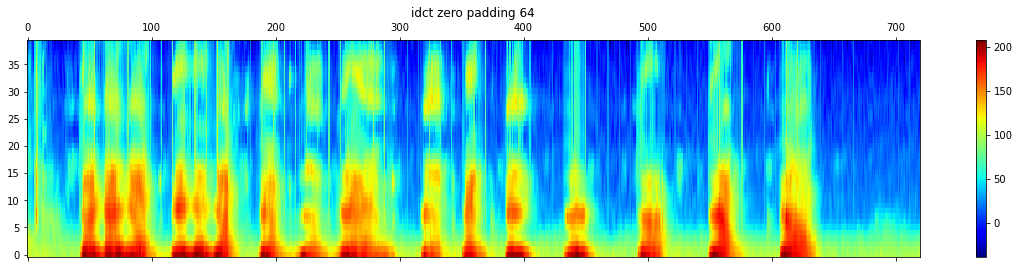

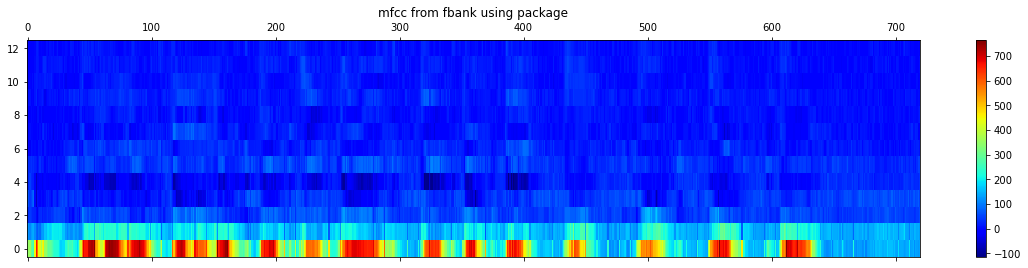

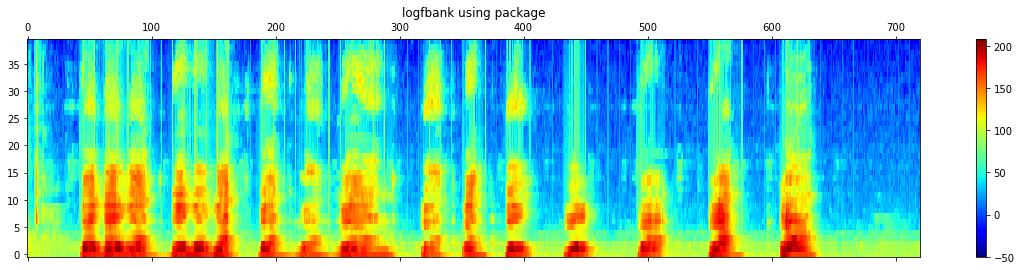

Too long time no one speaking, stop recording!
Audio data saved as Huangrui Chu.wav


In [61]:
rec=Recorder(FORMAT=pyaudio.paInt16, CHANNEL=1, RATE=16000,CHUNK=1600,VAD_setting=setting,Mel_setting=melsetting)
rec.start()

In [62]:
rec.terminate()

# Visualize the data

### Fetch the data

In [63]:
saved_data=rec._get_callback()
mfcc40=rec.mfcc
logmelspectrum40=rec.melspectrum

In [64]:
import IPython.display as ipd
ipd.Audio(saved_data,rate=16000)

## Visualize the melspectrum

In [65]:
def show_Mel_Log_Spectrum(Log_Mel_spectrum, filter_num):
    Log_Mel_spectrum=np.array(Log_Mel_spectrum).T
    plt.figure(figsize=(10,10))
    plt.imshow(Log_Mel_spectrum, origin='lower')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Mel Log Spectrum '+filter_num)
    
    plt.show()

## Visualize the cepstrum (MFCC)

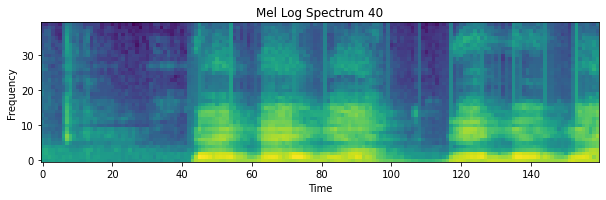

In [66]:
show_Mel_Log_Spectrum(logmelspectrum40[0:160], "40")

In [67]:
from scipy.fftpack import idct
def show_IDCT_logspectrum(mfcc, filter_num):
    IDCT_derived_logspectrum=[]
    for i in mfcc[0:160]:
        #i=zero_padding(i,FFT_size=128)
        IDCT_piece=idct(i,type=2, n=40, norm='ortho')
        IDCT_derived_logspectrum.append(IDCT_piece)
    IDCT_derived_logspectrum=np.array(IDCT_derived_logspectrum).T
    plt.figure(figsize=(10,10))
    plt.imshow(IDCT_derived_logspectrum, origin='lower')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('IDCT-derived Log Spectrum '+filter_num)
    
    plt.show()

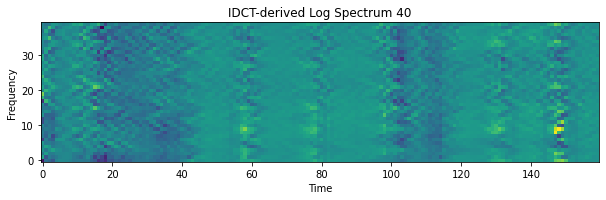

In [68]:
show_IDCT_logspectrum(mfcc40,"40")

In [69]:
def show_cepstrum(mfcc, filter_num):
    mfcc=np.array(mfcc).T
    plt.figure(figsize=(10,40))
    plt.imshow(mfcc, origin='lower')
    plt.xlabel('Time')
    #plt.ylabel('Frequency')
    plt.title('Cepstrum '+filter_num)
    
    plt.show()

### Retrive the data and try to use different filter banks

In [34]:
Preemphasizeddata=Preemphasizing(saved_data) 
newframes=rec._chunk2frames(Preemphasizeddata)
#logmelspectrum
logmelspectrum30=[]
logmelspectrum25=[]
mfcc30=[]
mfcc25=[]
for frame in newframes:
    frame=windowing(frame)
    frame=zero_padding(frame)
    power_spectrum=FFT(frame)
    Log_Mel_spectrum30=filterbanks(power_spectrum,num_banks=30)
    Log_Mel_spectrum25=filterbanks(power_spectrum,num_banks=25)
    logmelspectrum30.append(Log_Mel_spectrum30)
    logmelspectrum25.append(Log_Mel_spectrum25)
    mfcc_30=dct(Log_Mel_spectrum30, type=2, norm='ortho')[1 : (13 + 1)] # Keep 2-13
    mfcc_25=dct(Log_Mel_spectrum25, type=2, norm='ortho')[1 : (13+ 1)] # Keep 2-13
    mfcc30.append(mfcc_30)
    mfcc25.append(mfcc_25)

## Visualize both spectrograms with 3 different filter banks

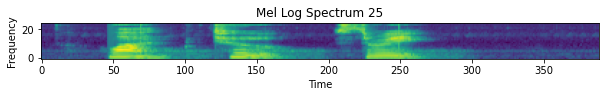

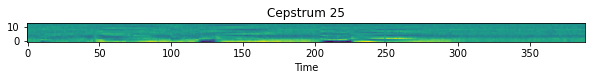

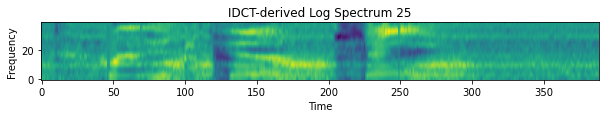

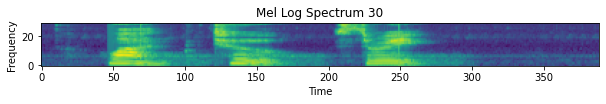

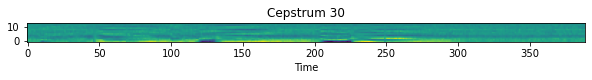

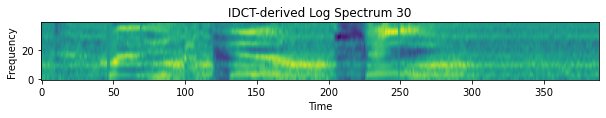

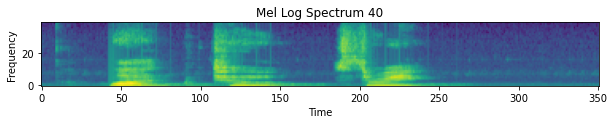

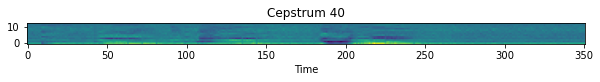

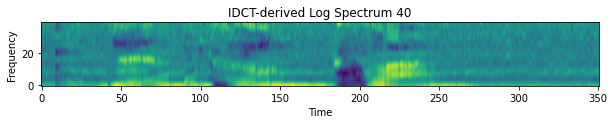

In [35]:
logmels=[logmelspectrum25, logmelspectrum30, logmelspectrum40]
mfccs=[mfcc25, mfcc30, mfcc40]
logmel=['logmelspectrum25', 'logmelspectrum30', 'logmelspectrum40']
mfcc=['mfcc25', 'mfcc30', 'mfcc40']
for i in range(0,3):
    show_Mel_Log_Spectrum(logmels[i], logmel[i][-2:])
    show_cepstrum(mfccs[i], mfcc[i][-2:])
    show_IDCT_logspectrum(mfccs[i], mfcc[i][-2:])

# Visualization of One Two Three 

In [46]:
def getMFCC(wave):
    Preemphasizeddata=Preemphasizing(wave) 
    newframes=rec._chunk2frames(Preemphasizeddata)
    #logmelspectrum
    logmelspectrum=[]
    mfcc=[]
    for frame in newframes:
        frame=windowing(frame)
        frame=zero_padding(frame)
        power_spectrum=FFT(frame)
        Log_Mel_spectrum=filterbanks(power_spectrum,num_banks=40)
        logmelspectrum.append(Log_Mel_spectrum)
        mfcc_40=dct(Log_Mel_spectrum, type=2, norm='ortho')[1 : (13 + 1)] # Keep 2-13
        mfcc.append(mfcc_40)
    return np.array(logmelspectrum),np.array(mfcc)

In [47]:
import soundfile as sf

one_sig,sr = sf.read("one.wav")
two_sig,sr = sf.read("two.wav")
three_sig,sr = sf.read("three.wav")

one_logmelspectrum,one_mfcc= getMFCC(one_sig)
two_logmelspectrum,two_mfcc= getMFCC(two_sig)
three_logmelspectrum,three_mfcc= getMFCC(three_sig)

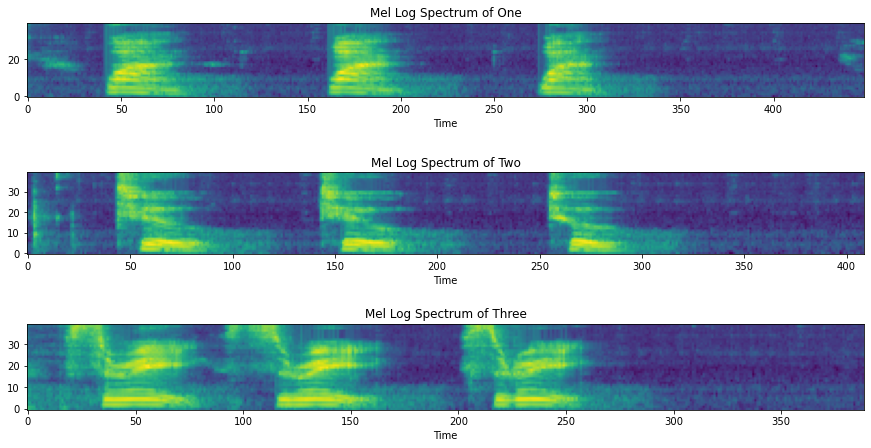

In [48]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
plt.imshow(one_logmelspectrum.T, origin='lower')
plt.xlabel('Time')
#plt.ylabel('Frequency')
plt.title('Mel Log Spectrum of One')

plt.subplot(312)
plt.imshow(two_logmelspectrum.T, origin='lower')
plt.xlabel('Time')
#plt.ylabel('Frequency')
plt.title('Mel Log Spectrum of Two')

plt.subplot(313)
plt.imshow(three_logmelspectrum.T, origin='lower')
plt.xlabel('Time')
#plt.ylabel('Frequency')
plt.title('Mel Log Spectrum of Three')


plt.savefig("Mel Log Spectrum comparison.png",dpi=300)
plt.show()

# Visualization of signal segment

In [34]:
frame=saved_data[0:320]
frame1=windowing(frame)
frame2=zero_padding(frame1, FFT_size=512)
power_spectrum=FFT(frame2, FFT_size=512)
Log_Mel_spectrum40=filterbanks(power_spectrum,lower_boundHz=133.33,upper_boundHz=6855.4976,num_banks=40,FFT_size=512)
num_ceps=13
mfcc40=dct(Log_Mel_spectrum40, type=2, norm='ortho')[1 : (num_ceps + 1)] # Keep 2-13


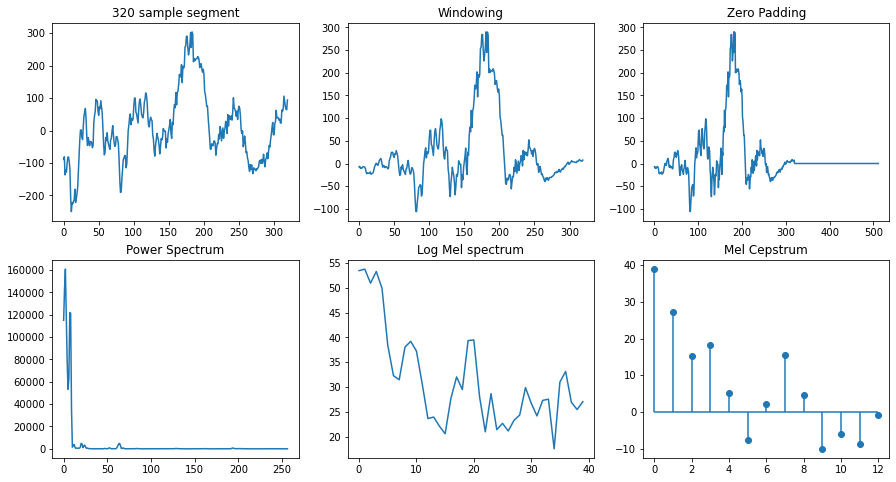

In [35]:
#Visualize the outcome of MFCC at each stage
plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.plot(frame)
plt.title('320 sample segment')

plt.subplot(232)
plt.plot(frame1)
plt.title('Windowing')

plt.subplot(233)
plt.plot(frame2)
plt.title('Zero Padding')

plt.subplot(234)
plt.plot(power_spectrum)
plt.title('Power Spectrum')

plt.subplot(235)
plt.plot(Log_Mel_spectrum40)
plt.title('Log Mel spectrum')

plt.subplot(236)
X=np.arange(0, 13, 1)
ymin=np.zeros(13)
plt.scatter(X, mfcc40)
plt.vlines(X, ymin, mfcc40)
plt.hlines(0, 0, 12)
plt.title('Mel Cepstrum')

plt.savefig("final result.png",dpi=300)
plt.show()